In [1]:
#pip install pandas

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(13)
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from scikeras.wrappers import KerasRegressor
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K 

KeyboardInterrupt: 

In [2]:
folder_benign_train = os.path.abspath(r'..\input\data\train\benign')
folder_malignant_train = os.path.abspath(r'..\input\data\train\malignant')

folder_benign_test = os.path.abspath(r'..\input\data\test\benign')
folder_malignant_test = os.path.abspath(r'..\input\data\test\malignant')


#folder_benign_train = '../input/data/train/benign'
#folder_malignant_train = '../input/data/train/malignant'

#folder_benign_test = '../input/data/test/benign'
#folder_malignant_test = '../input/data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

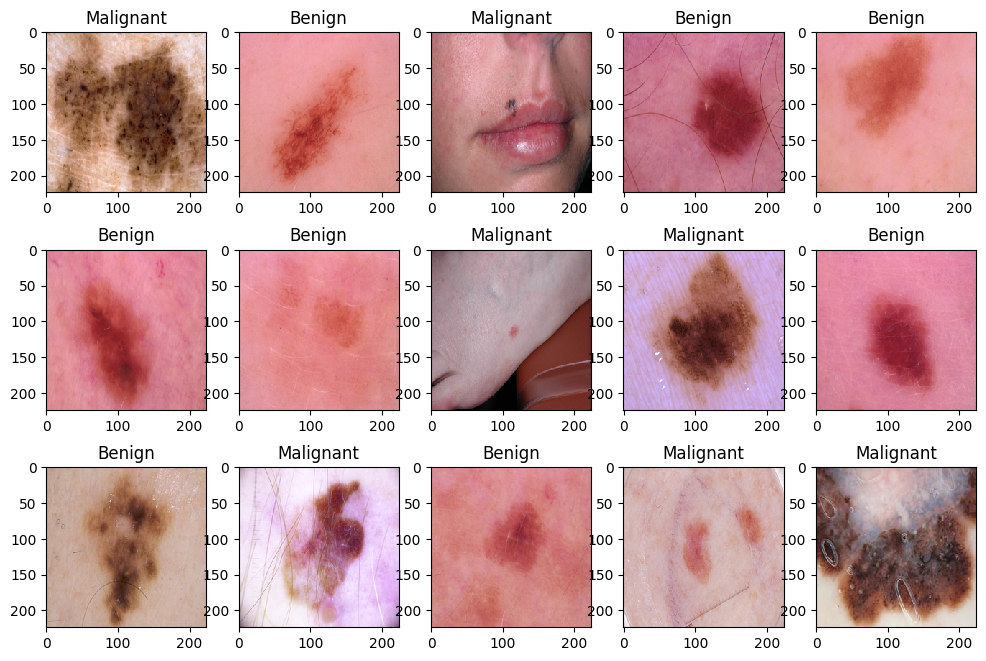

In [3]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [4]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [13]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

In [15]:
# See learning curve and validation curve

def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)       

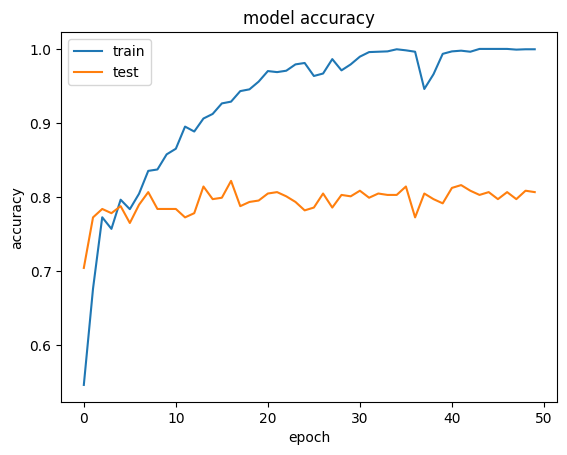

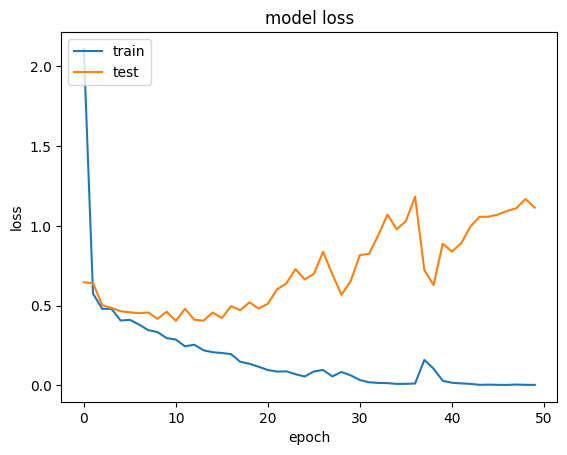

In [7]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )
                   
# list all data in history
# print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])  # 'accuracy' instead of 'acc'
plt.plot(history.history['val_accuracy'])  # 'val_accuracy' instead of 'val_acc'
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
K.clear_session()
del model
del history

In [9]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(X_train, y_train):
  # create model
    model = build(lr=lr, 
                  init= init, 
                  activ= activ, 
                  optim=optim, 
                  input_shape= input_shape)
    
    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

accuracy: 79.98%
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56,

accuracy: 80.43%
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56,

accuracy: 81.34%
80.58% (+/- 0.57%)


In [10]:
# Fitting model to all data
model = build(lr=lr, 
              init= init, 
              activ= activ, 
              optim=optim, 
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=0,
          callbacks=[learning_rate_reduction]
         )

# Testing model on test data to evaluate
#y_pred = model.predict_classes(X_test)
# Assuming model is your trained model
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Now you can use y_pred_classes for further analysis or evaluation


# print(accuracy_score(np.argmax(y_test, axis=1),y_pred))
print(accuracy_score(np.argmax(y_test, axis=1), y_pred_classes))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

21/21 [==============================] - 8s 311ms/step
0.8015151515151515


In [11]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# Clear memory, because of memory overload
del model
K.clear_session()

Saved model to disk


In [16]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/50


33/33 - 552s - loss: 0.6435 - accuracy: 0.7003 - val_loss: 0.6932 - val_accuracy: 0.4583 - lr: 1.0000e-05 - 552s/epoch - 17s/step
Epoch 2/50
33/33 - 462s - loss: 0.4725 - accuracy: 0.7667 - val_loss: 0.6912 - val_accuracy: 0.5417 - lr: 1.0000e-05 - 462s/epoch - 14s/step
Epoch 3/50


KeyboardInterrupt: 

In [ ]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )

In [ ]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")